# **IMPORT LIBRARY**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn._config import set_config
set_config(print_changed_only=False)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# **MERGE DATA**

In [ ]:
# === 1. LOAD MAIN DATA ===
app_train = pd.read_csv('DATA/application_train.csv')
app_test = pd.read_csv('DATA/application_test.csv')

# Tambahkan kolom "is_train"
app_train['is_train'] = 1
app_test['is_train'] = 0

# Gabungkan train & test agar proses feature engineering konsisten
app = pd.concat([app_train, app_test], axis=0, ignore_index=True)

# === 2. BUREAU + BUREAU_BALANCE ===
bureau = pd.read_csv('DATA/bureau.csv')
bureau_bal = pd.read_csv('DATA/bureau_balance.csv')

# Agregasi bureau_balance
bb_agg = (bureau_bal
          .groupby('SK_ID_BUREAU')
          .agg({'MONTHS_BALANCE': ['min', 'max', 'size']}))
bb_agg.columns = ['BB_MONTHS_MIN', 'BB_MONTHS_MAX', 'BB_COUNT']
bb_agg.reset_index(inplace=True)

# Gabungkan ke bureau
bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

# Agregasi bureau per SK_ID_CURR
bureau_agg = (bureau
              .groupby('SK_ID_CURR')
              .agg({
                  'DAYS_CREDIT': ['mean', 'min', 'max'],
                  'CREDIT_DAY_OVERDUE': ['mean', 'max'],
                  'AMT_CREDIT_SUM': ['mean', 'sum'],
                  'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
                  'BB_COUNT': ['mean', 'sum']
              }))
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

# Gabung ke app
app = app.merge(bureau_agg, on='SK_ID_CURR', how='left')

# === 3. PREVIOUS_APPLICATION + INSTALLMENTS_PAYMENTS ===
prev = pd.read_csv('DATA/previous_application.csv')
install = pd.read_csv('DATA/installments_payments.csv')

# Agregasi installments per SK_ID_PREV
install_agg = (install.groupby('SK_ID_PREV')
               .agg({'DAYS_INSTALMENT': ['mean', 'min', 'max'],
                     'AMT_PAYMENT': ['mean', 'sum'],
                     'AMT_INSTALMENT': ['mean', 'sum']}))
install_agg.columns = ['IN_' + '_'.join(col).upper() for col in install_agg.columns]
install_agg.reset_index(inplace=True)

# Gabung ke previous_application
prev = prev.merge(install_agg, on='SK_ID_PREV', how='left')

# Agregasi previous_application per SK_ID_CURR
prev_agg = (prev.groupby('SK_ID_CURR')
            .agg({'AMT_APPLICATION': ['mean', 'max'],
                  'AMT_CREDIT': ['mean', 'max'],
                  'DAYS_DECISION': ['mean', 'min', 'max'],
                  'IN_AMT_PAYMENT_SUM': ['mean', 'sum']}))
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)

# Gabung ke app
app = app.merge(prev_agg, on='SK_ID_CURR', how='left')

# === 4. POS_CASH_balance ===
pos = pd.read_csv('DATA/POS_CASH_balance.csv')
pos_agg = (pos.groupby('SK_ID_CURR')
           .agg({'MONTHS_BALANCE': ['min', 'max', 'size'],
                 'CNT_INSTALMENT': ['mean'],
                 'CNT_INSTALMENT_FUTURE': ['mean']}))
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]
pos_agg.reset_index(inplace=True)
app = app.merge(pos_agg, on='SK_ID_CURR', how='left')

# === 5. CREDIT_CARD_balance ===
cc = pd.read_csv('DATA/credit_card_balance.csv')
cc_agg = (cc.groupby('SK_ID_CURR')
          .agg({'MONTHS_BALANCE': ['min', 'max', 'size'],
                'AMT_BALANCE': ['mean', 'max'],
                'AMT_CREDIT_LIMIT_ACTUAL': ['mean']}))
cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]
cc_agg.reset_index(inplace=True)
app = app.merge(cc_agg, on='SK_ID_CURR', how='left')

# === 6. HASIL AKHIR ===
# Pisahkan kembali train dan test
train_final = app[app['is_train'] == 1].drop(columns=['is_train'])
test_final = app[app['is_train'] == 0].drop(columns=['is_train', 'TARGET'], errors='ignore')

print("✅ Dataset gabungan selesai dibuat!")
print("Ukuran final train:", train_final.shape)


✅ Dataset gabungan selesai dibuat!
Ukuran final train: (307511, 153)


In [ ]:
# Simpan hasil
train_final.to_csv('final_train_dataset.csv', index=False)
test_final.to_csv('final_test_dataset.csv', index=False)

# **TRAIN**

## **EDA**

In [2]:
df_train = pd.read_csv("final_train_dataset.csv")
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_SIZE,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-1.0,19.0,24.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-18.0,28.0,10.107143,5.785714,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-24.0,4.0,3.750000,2.250000,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-1.0,21.0,12.000000,8.650000,-6.0,-1.0,6.0,0.0,0.0,270000.0
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1.0,66.0,15.333333,8.969697,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 153 entries, SK_ID_CURR to CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
dtypes: float64(97), int64(40), object(16)
memory usage: 359.0+ MB


In [4]:
cat_cols = df_train.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"\nUnique values in {col}:")
    print(df_train[col].unique())
    print(f"Total categories: {df_train[col].nunique()}")


Unique values in NAME_CONTRACT_TYPE:
['Cash loans' 'Revolving loans']
Total categories: 2

Unique values in CODE_GENDER:
['M' 'F' 'XNA']
Total categories: 3

Unique values in FLAG_OWN_CAR:
['N' 'Y']
Total categories: 2

Unique values in FLAG_OWN_REALTY:
['Y' 'N']
Total categories: 2

Unique values in NAME_TYPE_SUITE:
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
Total categories: 7

Unique values in NAME_INCOME_TYPE:
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
Total categories: 8

Unique values in NAME_EDUCATION_TYPE:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Total categories: 5

Unique values in NAME_FAMILY_STATUS:
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
Total categories: 6

Unique values in NAME_HOUSING_TYPE:
['House / apartment' 'Rented apartment'

In [5]:
df_train.describe(include="object").style.set_properties(**{'background-color':'purple','color':'white','border-color':"#B97CFF"})

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [6]:
df_train.describe(exclude="object").style.set_properties(**{'background-color':'purple','color':'white','border-color':"#B97CFF"})

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_BB_COUNT_MEAN,BUREAU_BB_COUNT_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_IN_AMT_PAYMENT_SUM_MEAN,PREV_IN_AMT_PAYMENT_SUM_SUM,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_SIZE,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307499.000000,307233.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,306851.000000,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,30

## **PREPROCESSING**

In [7]:
print(df_train.isnull().sum())
print(f"\nTotal Missing Value: {df_train.isnull().sum().sum()}")

SK_ID_CURR                              0
TARGET                                  0
NAME_CONTRACT_TYPE                      0
CODE_GENDER                             0
FLAG_OWN_CAR                            0
                                    ...  
CC_MONTHS_BALANCE_MAX              220606
CC_MONTHS_BALANCE_SIZE             220606
CC_AMT_BALANCE_MEAN                220606
CC_AMT_BALANCE_MAX                 220606
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN    220606
Length: 153, dtype: int64

Total Missing Value: 11379062


In [8]:
# Menampilkan kolom dengan missing value
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("Kolom dengan Missing Value:")
print("==========================")

# Tambahkan persentase missing value
total_rows = len(df_train)
missing_percentage = (missing_values / total_rows * 100).round(2)

# Buat DataFrame untuk tampilan yang lebih rapi
missing_df = pd.DataFrame({
    'Jumlah Missing': missing_values,
    'Persentase Missing (%)': missing_percentage
})

# Tampilkan dengan format yang rapi
display(missing_df.style.background_gradient(cmap='Purples')
        .format({
            'Jumlah Missing': '{:,.0f}',
            'Persentase Missing (%)': '{:.2f}%'
        }))

Kolom dengan Missing Value:


,Jumlah Missing,Persentase Missing (%)
CC_MONTHS_BALANCE_MAX,"220,606",71.74%
CC_MONTHS_BALANCE_MIN,"220,606",71.74%
CC_AMT_BALANCE_MEAN,"220,606",71.74%
CC_MONTHS_BALANCE_SIZE,"220,606",71.74%
CC_AMT_BALANCE_MAX,"220,606",71.74%
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,"220,606",71.74%
BUREAU_BB_COUNT_MEAN,"215,280",70.01%
COMMONAREA_MEDI,"214,865",69.87%
COMMONAREA_MODE,"214,865",69.87%
COMMONAREA_AVG,"214,865",69.87%


In [9]:
def fill_missing_values(df):
    df_clean = df.copy()
    
    # Kategorisasi kolom berdasarkan nama
    amount_cols = [col for col in df.columns if any(x in col.upper() for x in ['AMT', 'AMOUNT'])]
    mean_cols = [col for col in df.columns if 'MEAN' in col.upper()]
    count_cols = [col for col in df.columns if any(x in col.upper() for x in ['CNT', 'COUNT'])]
    days_cols = [col for col in df.columns if 'DAYS' in col.upper()]
    sum_cols = [col for col in df.columns if 'SUM' in col.upper()]
    min_cols = [col for col in df.columns if 'MIN' in col.upper()]
    max_cols = [col for col in df.columns if 'MAX' in col.upper()]
    
    # Mengisi missing values berdasarkan kategori
    print("Mengisi missing values...")
    
    # Amount - Median
    for col in amount_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan median")
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Mean - Mean/Average
    for col in mean_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan mean")
            df_clean[col].fillna(df_clean[col].mean(), inplace=True)
    
    # Count - Mode
    for col in count_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan modus")
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # Days - Median
    for col in days_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan median")
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Sum - Mean
    for col in sum_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan mean")
            df_clean[col].fillna(df_clean[col].mean(), inplace=True)
    
    # Min - Min
    for col in min_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan minimum")
            df_clean[col].fillna(df_clean[col].min(), inplace=True)
    
    # Max - Max
    for col in max_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan maximum")
            df_clean[col].fillna(df_clean[col].max(), inplace=True)
    
    # Kolom kategorikal - Mode
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan modus")
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # Kolom sisanya - Forward fill dan backward fill
    remaining_cols = df_clean.columns[df_clean.isnull().sum() > 0]
    for col in remaining_cols:
        if df_clean[col].isnull().sum() > 0:
            print(f"Mengisi {col} dengan forward/backward fill")
            df_clean[col].fillna(method='ffill', inplace=True)
            df_clean[col].fillna(method='bfill', inplace=True)
    
    # Cek hasil
    missing_after = df_clean.isnull().sum().sum()
    print(f"\nTotal missing values setelah diisi: {missing_after}")
    
    return df_clean

# Aplikasikan fungsi ke dataset
df_train_clean = fill_missing_values(df_train)

# Tampilkan jumlah missing values setelah diisi
print("\nJumlah missing values per kolom setelah diisi:")
missing_after = df_train_clean.isnull().sum()
missing_after = missing_after[missing_after > 0]
if len(missing_after) > 0:
    print(missing_after)
else:
    print("Tidak ada missing value tersisa")

Mengisi missing values...
Mengisi AMT_ANNUITY dengan median
Mengisi AMT_GOODS_PRICE dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_HOUR dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_DAY dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_WEEK dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_MON dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_QRT dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_YEAR dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_MEAN dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_SUM dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_DEBT_MEAN dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_DEBT_SUM dengan median
Mengisi PREV_AMT_APPLICATION_MEAN dengan median
Mengisi PREV_AMT_APPLICATION_MAX dengan median
Mengisi PREV_AMT_CREDIT_MEAN dengan median
Mengisi PREV_AMT_CREDIT_MAX dengan median
Mengisi PREV_IN_AMT_PAYMENT_SUM_MEAN dengan median
Mengisi PREV_IN_AMT_PAYMENT_SUM_SUM dengan median
Mengisi CC_AMT_BALANCE_MEAN dengan median
Mengisi CC_AMT_BALANCE_MAX dengan median
Mengisi CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN den

In [10]:
df_train_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_SIZE,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-1.0,19.0,24.000000,15.000000,-96.0,-1.0,6.0,26793.606316,97424.325,149727.272727
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-18.0,28.0,10.107143,5.785714,-96.0,-1.0,6.0,26793.606316,97424.325,149727.272727
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-24.0,4.0,3.750000,2.250000,-96.0,-1.0,6.0,26793.606316,97424.325,149727.272727
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-1.0,21.0,12.000000,8.650000,-6.0,-1.0,6.0,0.000000,0.000,270000.000000
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1.0,66.0,15.333333,8.969697,-96.0,-1.0,6.0,26793.606316,97424.325,149727.272727


In [11]:
# Pisahkan fitur dan target
X = df_train_clean.drop(['SK_ID_CURR', 'TARGET'], axis=1)  # Hapus kolom ID dan target
y = df_train_clean['TARGET']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,  # 75% training, 25% testing 
    random_state=42,  # Untuk reproducibility
    stratify=y  # Memastikan distribusi kelas target seimbang
)

# Identifikasi kolom numerikal dan kategorikal
num_cols = X_train.select_dtypes(exclude=['object']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Scaling untuk kolom numerikal
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Tampilkan informasi hasil splitting
print("Ukuran dataset setelah splitting:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Tampilkan distribusi kelas target
print("\nDistribusi kelas target:")
print("Training set:")
print(y_train.value_counts(normalize=True))
print("\nTesting set:")
print(y_test.value_counts(normalize=True))

Ukuran dataset setelah splitting:
X_train: (230633, 151)
X_test: (76878, 151)
y_train: (230633,)
y_test: (76878,)

Distribusi kelas target:
Training set:
TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64

Testing set:
TARGET
0.0    0.919275
1.0    0.080725
Name: proportion, dtype: float64


Distribusi kelas sebelum SMOTE:
Counter({0.0: 212014, 1.0: 18619})

Distribusi kelas setelah SMOTE:
Counter({0.0: 212014, 1.0: 212014})


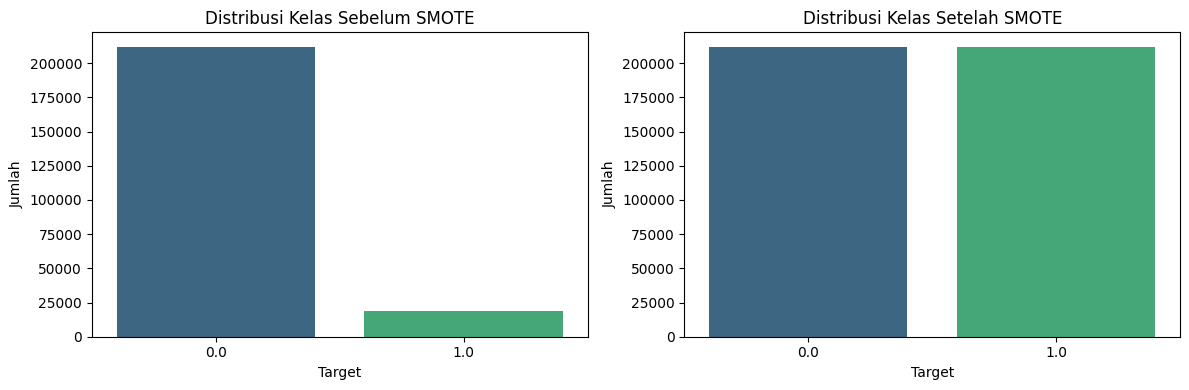


Ukuran dataset setelah SMOTE:
X_train: (424028, 151)
y_train: (424028,)


In [12]:
# Identifikasi kolom kategorikal
cat_cols = X_train.select_dtypes(include=['object']).columns

# Encoding kolom kategorikal
le = LabelEncoder()
for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# Terapkan SMOTE setelah encoding
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Tampilkan perbandingan distribusi
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y_train))
print("\nDistribusi kelas setelah SMOTE:")
print(Counter(y_train_balanced))

# Visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Sebelum SMOTE
sns.countplot(x=y_train, ax=ax1, palette='viridis')
ax1.set_title('Distribusi Kelas Sebelum SMOTE')
ax1.set_xlabel('Target')
ax1.set_ylabel('Jumlah')

# Setelah SMOTE
sns.countplot(x=y_train_balanced, ax=ax2, palette='viridis')
ax2.set_title('Distribusi Kelas Setelah SMOTE')
ax2.set_xlabel('Target')
ax2.set_ylabel('Jumlah')

plt.tight_layout()
plt.show()

# Update data training
X_train = X_train_balanced
y_train = y_train_balanced

print("\nUkuran dataset setelah SMOTE:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# **MODELLING**

## **CATBOOST**

Melatih model CatBoost...
0:	test: 0.6262241	best: 0.6262241 (0)	total: 154ms	remaining: 2m 34s
100:	test: 0.7440258	best: 0.7440258 (100)	total: 5.21s	remaining: 46.4s
200:	test: 0.7576734	best: 0.7576734 (200)	total: 10.4s	remaining: 41.5s
300:	test: 0.7616878	best: 0.7616878 (300)	total: 15.6s	remaining: 36.3s
400:	test: 0.7629258	best: 0.7629765 (396)	total: 20.8s	remaining: 31.1s
500:	test: 0.7634797	best: 0.7636064 (485)	total: 28.4s	remaining: 28.3s
600:	test: 0.7638666	best: 0.7638666 (600)	total: 35.7s	remaining: 23.7s
700:	test: 0.7640179	best: 0.7640193 (650)	total: 42.7s	remaining: 18.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.764019273
bestIteration = 650

Shrink model to first 651 iterations.

Evaluasi Model:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70672
         1.0       0.52      0.04      0.07      6206

    accuracy                           0.92     768

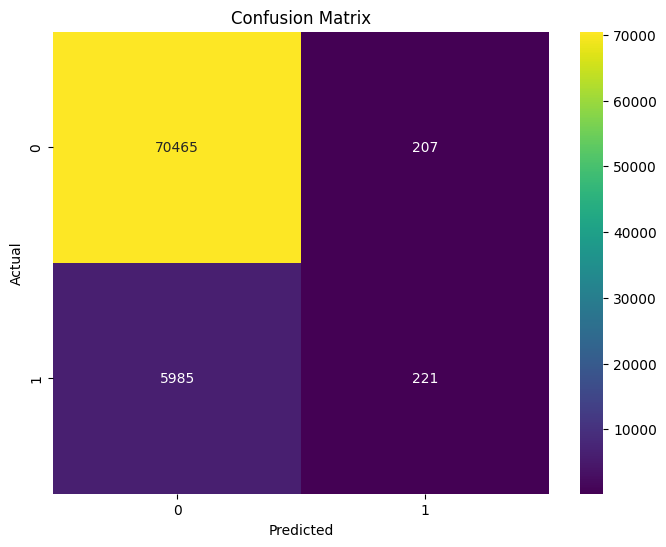

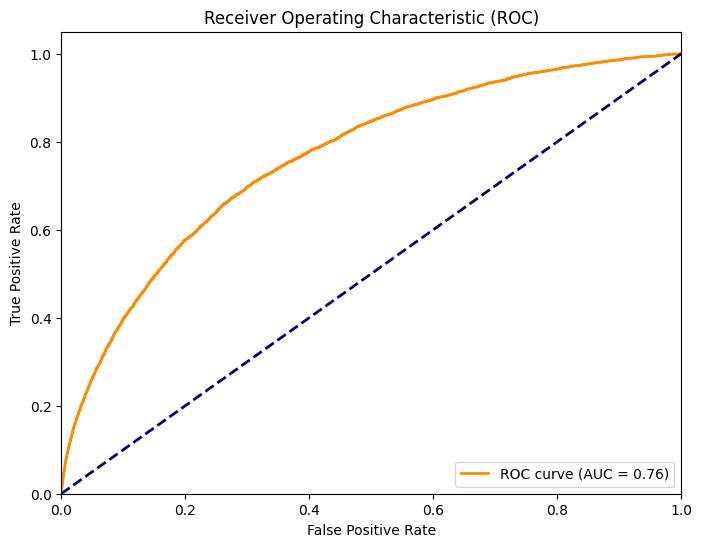

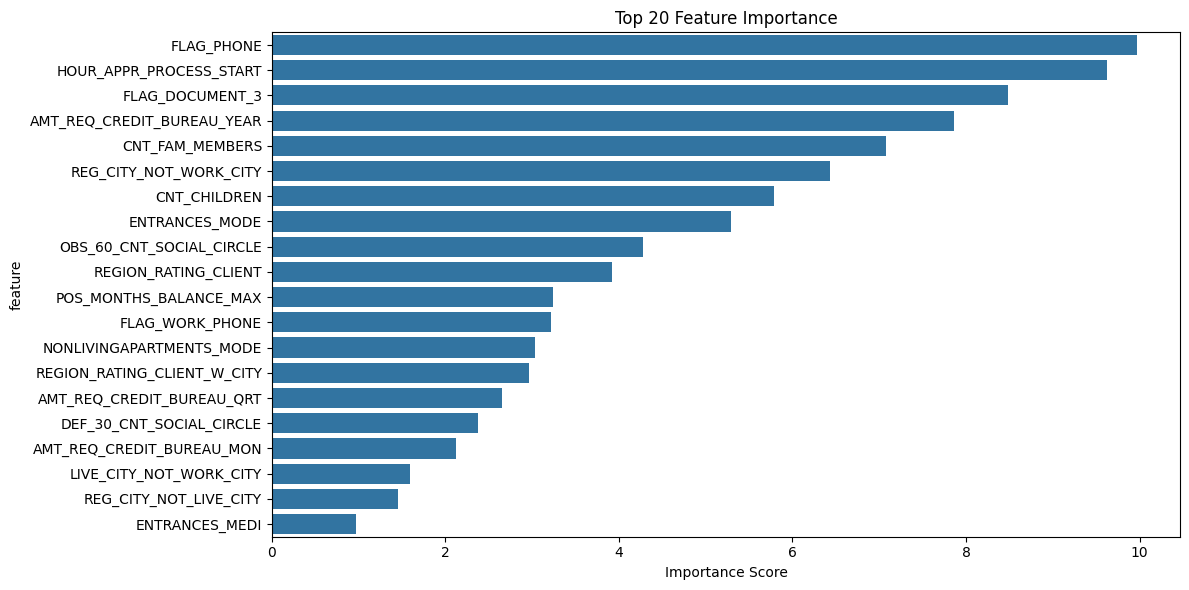

In [13]:
# Inisialisasi model CatBoost
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100  # Menampilkan progress setiap 100 iterasi
)

# Latih model
print("Melatih model CatBoost...")
cb_model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          early_stopping_rounds=50)

# Prediksi
y_pred = cb_model.predict(X_test)
y_pred_proba = cb_model.predict_proba(X_test)[:, 1]

# Evaluasi model
print("\nEvaluasi Model:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix dengan seaborn
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': cb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## **LOGISTIC REGRESSION**

Melatih model Logistic Regression...

Evaluasi Model Logistic Regression:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.59      0.73     70672
         1.0       0.11      0.60      0.19      6206

    accuracy                           0.59     76878
   macro avg       0.53      0.60      0.46     76878
weighted avg       0.88      0.59      0.68     76878



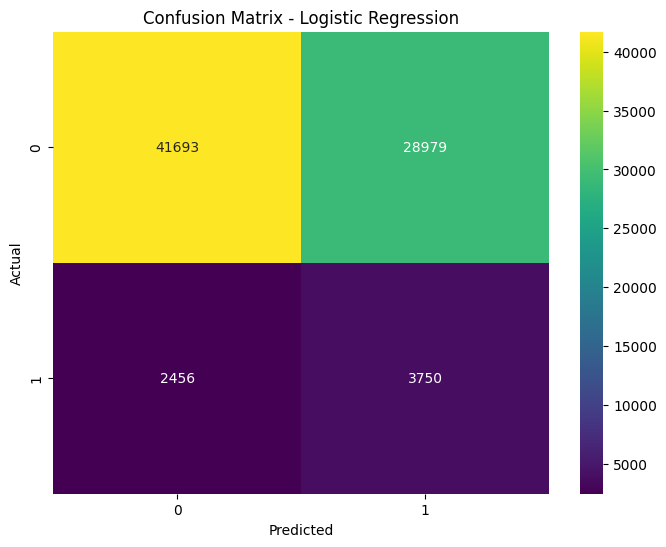

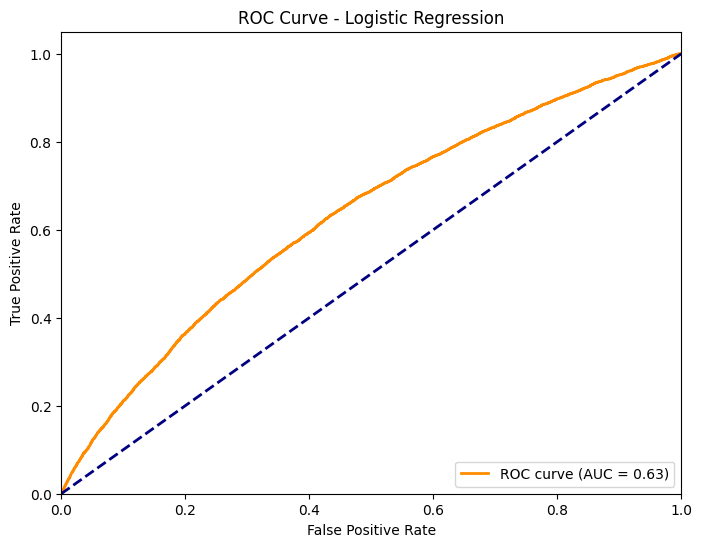

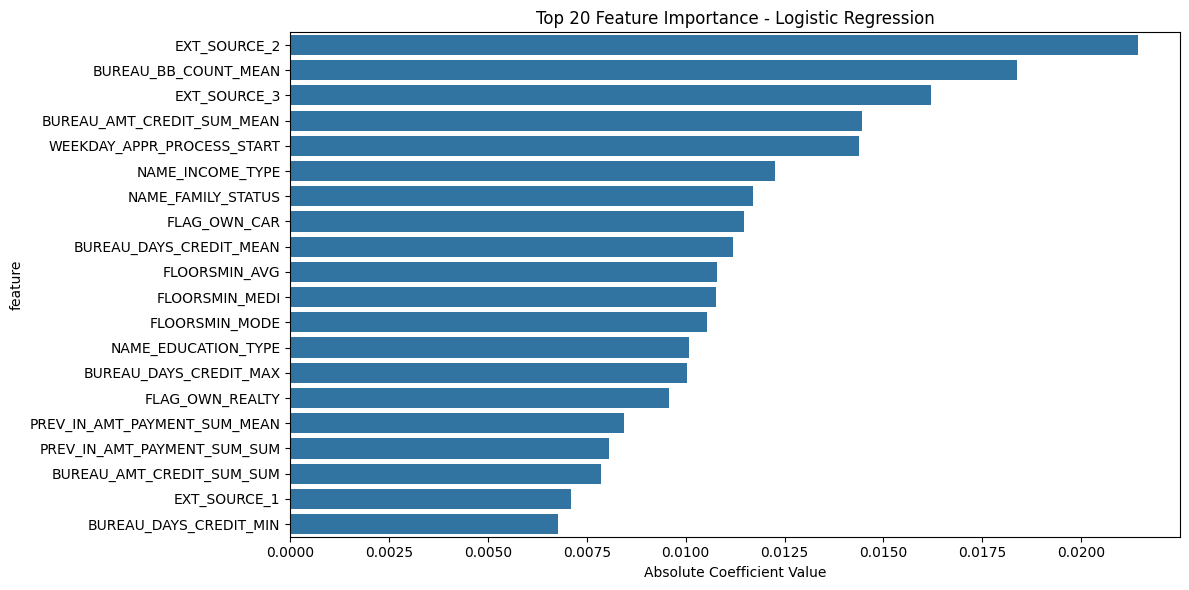


Model Accuracy: 0.5911


In [14]:
# Inisialisasi model Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

# Latih model
print("Melatih model Logistic Regression...")
lr_model.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluasi model
print("\nEvaluasi Model Logistic Regression:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Feature Importance (menggunakan koefisien)
feature_importance_lr = pd.DataFrame({
    'feature': X_train.columns,
    'importance': abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_lr.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Print model accuracy
print(f"\nModel Accuracy: {lr_model.score(X_test, y_test):.4f}")

# **TEST**

In [15]:
# Load data test
df_test = pd.read_csv("final_test_dataset.csv")

# Preprocessing data test
df_test_clean = fill_missing_values(df_test)

# Pastikan kolom yang sama dengan data training
X_submit = df_test_clean.drop(['SK_ID_CURR'], axis=1)
X_submit = X_submit[X_train.columns]  # Sesuaikan urutan kolom dengan data training

# Scaling fitur numerikal
num_cols = X_submit.select_dtypes(exclude=['object']).columns
X_submit[num_cols] = scaler.transform(X_submit[num_cols])

# Encoding fitur kategorikal 
cat_cols = X_submit.select_dtypes(include=['object']).columns
for col in cat_cols:
    try:
        X_submit[col] = le.transform(X_submit[col])
    except ValueError as e:
        print(f"Error pada kolom {col}: {e}")
        # Handle kategori baru yang mungkin muncul di data test
        unique_train = set(le.classes_)
        unique_test = set(X_submit[col].unique())
        new_categories = unique_test - unique_train
        if new_categories:
            print(f"Kategori baru ditemukan di {col}: {new_categories}")
            # Ganti kategori baru dengan modus dari data training
            mode_value = le.transform([le.classes_[0]])[0]  # Ambil kategori pertama sebagai default
            X_submit[col] = X_submit[col].map(lambda x: x if x in unique_train else le.classes_[0])
            X_submit[col] = le.transform(X_submit[col])


Mengisi missing values...
Mengisi AMT_ANNUITY dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_HOUR dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_DAY dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_WEEK dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_MON dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_QRT dengan median
Mengisi AMT_REQ_CREDIT_BUREAU_YEAR dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_MEAN dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_SUM dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_DEBT_MEAN dengan median
Mengisi BUREAU_AMT_CREDIT_SUM_DEBT_SUM dengan median
Mengisi PREV_AMT_APPLICATION_MEAN dengan median
Mengisi PREV_AMT_APPLICATION_MAX dengan median
Mengisi PREV_AMT_CREDIT_MEAN dengan median
Mengisi PREV_AMT_CREDIT_MAX dengan median
Mengisi PREV_IN_AMT_PAYMENT_SUM_MEAN dengan median
Mengisi PREV_IN_AMT_PAYMENT_SUM_SUM dengan median
Mengisi CC_AMT_BALANCE_MEAN dengan median
Mengisi CC_AMT_BALANCE_MAX dengan median
Mengisi CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN dengan median
Mengisi BUREAU_DAYS_CREDIT_

## **CATBOOST**

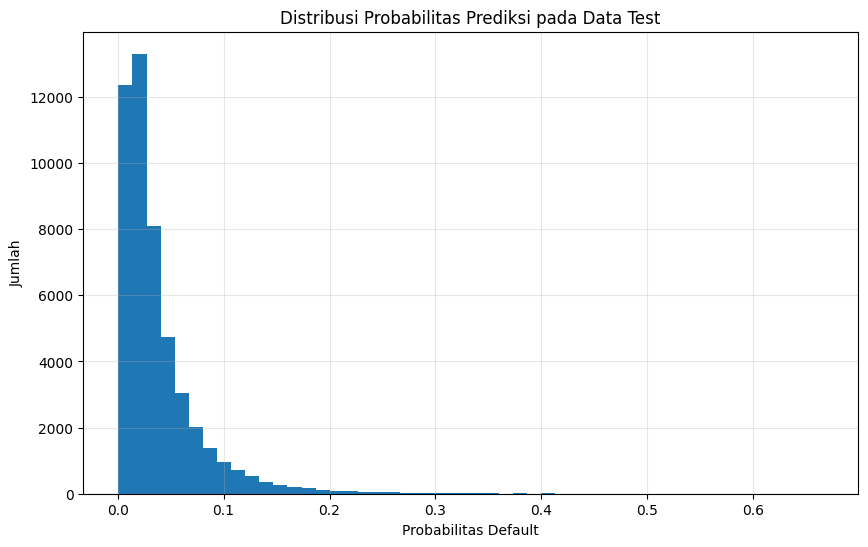


Statistik Hasil Prediksi:
count    48744.000000
mean         0.038415
std          0.040613
min          0.000681
25%          0.013845
50%          0.025604
75%          0.047723
max          0.665789
dtype: float64


In [17]:
# Prediksi probabilitas
test_pred_proba = cb_model.predict_proba(X_submit)[:, 1]
test_pred_binary = (test_pred_proba >= 0.5).astype(int)

# Buat DataFrame hasil prediksi
submission_cb = pd.DataFrame({
    'SK_ID_CURR': df_test_clean['SK_ID_CURR'],
    'TARGET': test_pred_binary
})

# Tampilkan distribusi probabilitas prediksi
plt.figure(figsize=(10, 6))
plt.hist(test_pred_proba, bins=50)
plt.title('Distribusi Probabilitas Prediksi pada Data Test')
plt.xlabel('Probabilitas Default')
plt.ylabel('Jumlah')
plt.grid(True, alpha=0.3)
plt.show()

# Tampilkan statistik hasil prediksi
print("\nStatistik Hasil Prediksi:")
print(pd.Series(test_pred_proba).describe())

In [22]:
submission_cb.head(10)

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
5,100042,0
6,100057,0
7,100065,0
8,100066,0
9,100067,0


In [ ]:
submission_cb.to_csv('submission_cb_siven.csv', index=False)

## **LOGISTIC REGRESSION**

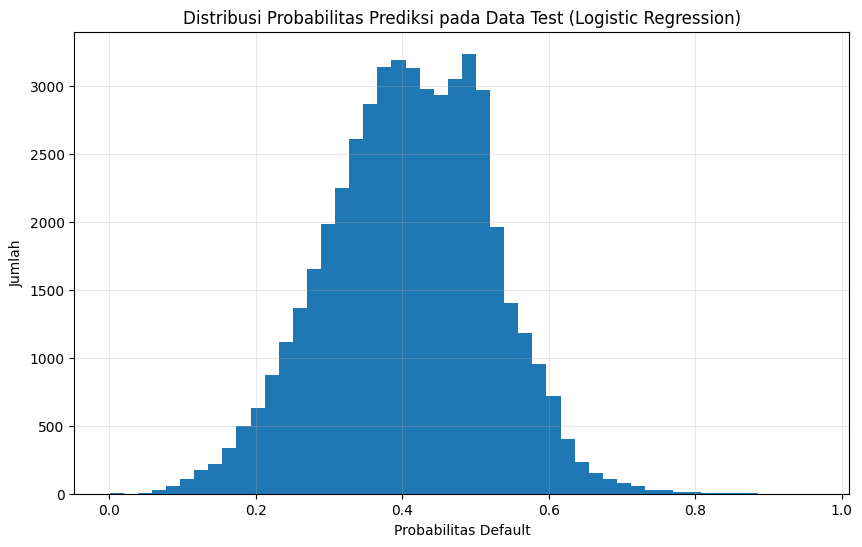


Statistik Hasil Prediksi (Logistic Regression):
count    48744.000000
mean         0.409444
std          0.111021
min          0.000585
25%          0.334322
50%          0.412099
75%          0.489752
max          0.962240
dtype: float64

Sample Hasil Prediksi:
    SK_ID_CURR  TARGET
0       100001       0
1       100005       1
2       100013       0
3       100028       0
4       100038       0
5       100042       0
6       100057       0
7       100065       0
8       100066       0
9       100067       1
10      100074       0
11      100090       0
12      100091       1
13      100092       0
14      100106       0
15      100107       1
16      100109       0
17      100117       0
18      100128       0
19      100141       0


In [21]:
# Prediksi menggunakan model Logistic Regression
test_pred_proba_lr = lr_model.predict_proba(X_submit)[:, 1]
test_pred_binary_lr = (test_pred_proba_lr >= 0.5).astype(int)

# Buat DataFrame hasil prediksi
submission_lr = pd.DataFrame({
    'SK_ID_CURR': df_test_clean['SK_ID_CURR'],
    'TARGET': test_pred_binary_lr
})

# Tampilkan distribusi probabilitas prediksi
plt.figure(figsize=(10, 6))
plt.hist(test_pred_proba_lr, bins=50)
plt.title('Distribusi Probabilitas Prediksi pada Data Test (Logistic Regression)')
plt.xlabel('Probabilitas Default')
plt.ylabel('Jumlah')
plt.grid(True, alpha=0.3)
plt.show()

# Tampilkan statistik hasil prediksi
print("\nStatistik Hasil Prediksi (Logistic Regression):")
print(pd.Series(test_pred_proba_lr).describe())

# Tampilkan beberapa hasil prediksi
print("\nSample Hasil Prediksi:")
print(submission_lr.head(20))

In [23]:
submission_lr.head(10)

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,0
5,100042,0
6,100057,0
7,100065,0
8,100066,0
9,100067,1


In [24]:
submission_lr.to_csv('submission_lr_siven.csv', index=False)